# TensorFlow 2.0 alpha - Regression
## Predict Fuel Efficiency - using the Auto MPG dataset

In [2]:
from __future__ import absolute_import, division, print_function

import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Get the Dataset from the UCI ML Repository

In [3]:
# download the dataset

dataset_path = keras.utils.get_file("auto-mpg.data", 
                                    "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 1us/step


'/Users/MPHA/.keras/datasets/auto-mpg.data'

In [4]:
# import with Pandas

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
               'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values='?',
                         comment='\t', sep=' ', skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Clean the Data - Unknown Values

In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
# Drop those rows - for the simplicity of this exercise

dataset = dataset.dropna()

#### *Origin*, is actually a Categorical variable  -  one-hot encode it

In [7]:
origin = dataset.pop('Origin')

dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


## Split Data into Training and Testing sets

In [8]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Explore the Data

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


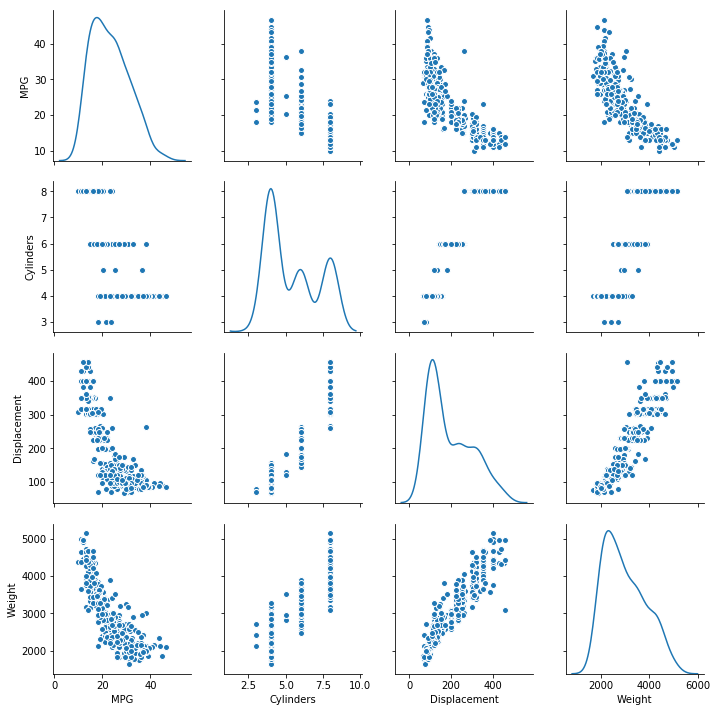

In [10]:
# Plot the joint distribution of a few pairs of Training set columns

sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], 
             diag_kind='kde')

In [12]:
# Look at the statistics

train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### Split the Target, MPG, from the other Features

In [13]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalize the Data
#### Many features are of varying scales and ranges - it is good practice to normalize - the Statistics used to normalize, will be Generated from the Training data (but also used to normalize the Test data)

In [14]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# data will be standardized

# Build the Model
### Use a Sequential Model - with 2 Dense Hidden Layers, and Output Layer returnign a single, continuous value
### Wrap the Model Building Steps in a Function (building a 2nd model later)

In [15]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae','mse'])
    return model

In [17]:
model = build_model()

## Inspect the Model

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Try the model on a Batch of 10 examples from Training data

example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.11897676],
       [-0.05936302],
       [ 0.40748838],
       [-0.39265177],
       [-0.07002646],
       [ 0.1955271 ],
       [-0.04268974],
       [ 0.45947048],
       [ 0.2008206 ],
       [ 0.29956698]], dtype=float32)

## Train the Model
#### Train for 1000 epochs - store Training and Validation accuracy in the HISTORY Object

In [21]:
# Display Training progress - Print a single dot, for each completed epoch

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                   validation_split=0.2, verbose=0, callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [22]:
# Visualize the Training progress - using HISTORY Object

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,3.304266,1.210319,3.304266,8.621653,2.275948,8.621654,995
996,3.104053,1.109333,3.104053,8.513306,2.250889,8.513306,996
997,3.067572,1.118682,3.067573,8.418439,2.260573,8.418439,997
998,3.151381,1.164514,3.151381,8.559701,2.291265,8.559701,998
999,3.016504,1.105120,3.016504,8.559015,2.282068,8.559015,999


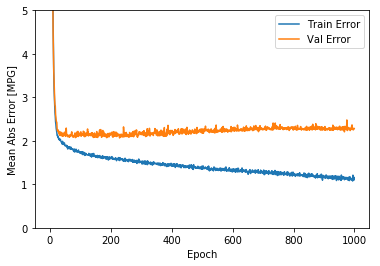

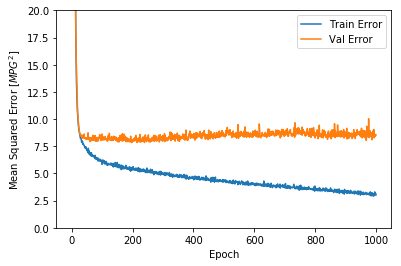

In [25]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
    plt.ylim([0,5])
    plt.legend()
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

plot_history(history)

### Little improvement, in Validation error beyond around 100 - 110 epochs
### Update *model.fit* - automatically stop training when validation score stops improving - if a determined amt of epochs elapses without improvement, stop training


..................................................................................................

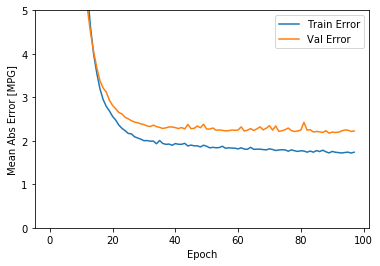

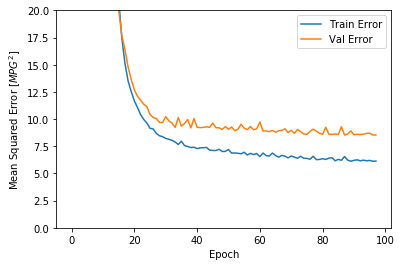

In [26]:
# EarlyStopping callback - tests a training condition for each epoch

model = build_model()

# patience parameter - amt of epochs to check for improvement

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                   validation_split=0.2, verbose=0, callbacks=[early_stop,
                                                              PrintDot()])
plot_history(history)

## Evaulate the Model with the Test set

In [27]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print('Testing set Mean Abs Error: {:5.2f} MPG'.format(mae))

Testing set Mean Abs Error:  1.93 MPG


## Make MPG Predictions with the Test set

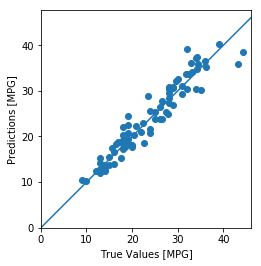

In [28]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100,100])

### Model appears to predict well - Look at the Error Distribution

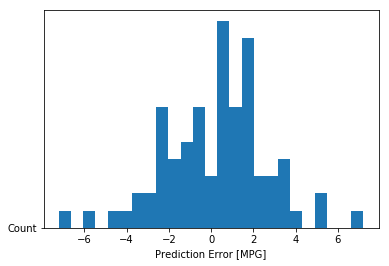

In [29]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.plot('Count')

# Conclusion
### Common Metrics for evaluating regression are MSE and MAE
### Numeric input data with quite varied ranges, should be Normalized
### Prevent Overfitting - with Early Stopping, or few hidden layers

In [30]:
# notes supporting this exercise - from tensorflow.org - Permission granted
#
##@title MIT License
#
# Copyright (c) 2017 François Chollet